# Problem 3

### Initialize data and libraries

In [1]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt

import torch
from torch.nn import Parameter
import torch.optim as optim
from torch import utils,nn
from torch import flatten
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets
from torchsummary import summary


### Define Helper Functions

In [2]:
def train_val_split(X,y,p=0.1,seed=42):
    """
    train_val_split: Splits the given data into Train/Val sets

    input: 
        - X: Input data
        - y: Output data
    output:
        - Xtr: Input train set
        - ytr: Output train set
        - Xval: Input validation set
        - yval: Output validation set
    """
    np.random.seed(seed)
    n_samples = X.shape[0]
    #Select 10% for Validation set 
    val_idx = np.random.choice(range(n_samples),int(n_samples*p))
    mask = np.ones(n_samples,dtype=np.bool)
    mask[val_idx] = False
    
    Xval = X[~mask].copy()
    Xtr = X[mask].copy()
    Ytr =  y[mask].copy()
    Yval =  y[~mask].copy()
    return Xtr, Xval, Ytr, Yval


def calculate_dims(length):
    """
    calculate_dims: Takes a number, outputs best i,j such that i*j=number
    It will help us display images 
    """
    i = 1
    j = length
    while i<j and j%2 == 0:
        i*=2
        j//=2
    return i,j


We load the data and then split it into train/val sets.

In [3]:
data = np.load("data.npz")
list(data.keys())

['Xtr', 'y', 'Xte', 'testIds']

In [4]:
Xtr, Xval, Ytr, Yval = train_val_split(data["Xtr"],data["y"],p=.2,seed=42)
Xte = data["Xte"]
testId = data["testIds"]

In [5]:
#Check train/val data shape
print("X train shape =",Xtr.shape)
print("X val shape =",Xval.shape)

X train shape = (16416, 64, 64, 3)
X val shape = (3582, 64, 64, 3)


Next, we create a customized class in order to provide a wrapper for the data stored as a numpy object.
The classe inherits from default Dataset utility from Pytorch which only supports reading images directly from directories.

We needed here an altered Class because we didn't want to do the train validation split manuly on the data.

In [6]:
class CustomDataset(Dataset):
    """
    CustomDataset: An API wrapper for numpy Datasets
    """
    def __init__(self, X,y=None, transform=None,one_hot=False):
        self.X = X
        self.y = y
        self.transform = transform
        self.one_hot = one_hot
        self.raw_transforms = transforms.Compose([
            transforms.ToPILImage(),    
            transforms.ToTensor(),
            # we calculated the mean and std vector based on training data
            transforms.Normalize(mean=[0.48943359,0.41543327, 0.45436677], std=[0.25176669, 0.24699999, 0.24525466])
        ])
    def __len__(self):
        return len(self.X)
    
    #Override __getitem__ to adapt to our data
    def __getitem__(self, index,use_transforms = True):
        image = self.X[index,:].copy()
        if self.y is not None:
            if self.one_hot:
                label = self.y[index].astype(np.uint8)
            else:
                label = np.argmax(self.y[index]).astype(np.uint8)
        else:
            label=None
        
        if self.transform is not None and use_transforms:
            image = self.transform(image)
        else:
            image = self.raw_transforms(image)
        return image, label

In order to have more data, we performed Data Augmentation using different tranformatioms such as Horizontal Flipping, Cropping, Shearing along side with preprocessing step and Normalization.

In [7]:
val_test_transform = transforms.Compose([
    transforms.ToPILImage(),    
    transforms.ToTensor(),
    # we calculated the mean and std vector based on training data
    transforms.Normalize(mean=[0.48943359,0.41543327, 0.45436677], std=[0.25176669, 0.24699999, 0.24525466])
])
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(40,(.3,.3),(1.5,1.5),10),
    transforms.ToTensor(),
    # we calculated the mean and std vector based on training data
    transforms.Normalize(mean=[0.48943359,0.41543327, 0.45436677], std=[0.25176669, 0.24699999, 0.24525466])
])

train_dataset = CustomDataset(Xtr,Ytr,transform=data_transform)
val_dataset = CustomDataset(Xval,Yval,transform=val_test_transform)
test_dataset = CustomDataset(Xte,[None]*Xte.shape[0],transform=val_test_transform)

train_loader = utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = utils.data.DataLoader(val_dataset, batch_size=128, num_workers=4)
test_loader = utils.data.DataLoader(test_dataset, batch_size=800, num_workers=4)

# 1. Model Description and Training

In order to build the model, we adopted an iterative approach. At the beginning, we started with a simple convolutional model with 3 conv layers, then a fully connected one. Then we used a second model with more conv layers, and finally a third model with even more layers.

We also have tweaked other hyperparameters such as batch size, learning rate, applied transformations. We also have coded a basic weight decay algorithm to update the learning rate throughout the training process.

## 1.1. Model Description

In the final model (MonsterModel3), here is the configuration used: 7 convolutional layers sometimes followed by MaxPooling, and ReLU as the activation function. We then flatten the output of the last convolution to have a fully connected Neural Net just after.


In [8]:
class MonsterModel1(nn.Module):
    def __init__(self):
        super(MonsterModel1, self).__init__()
        """
        Conv -> RelU -> MaxPool -> Conv -> ReLU -> MaxPool -> Conv -> ReLU -> Flatten -> Dense 
        """
        self.clf = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=(5,5),stride=2),
            nn.ReLU(),
        )
        self.flat_fts = self.get_flat_fts((3,64,64), self.clf)
        self.dense = nn.Sequential(
            nn.Linear(in_features=self.flat_fts ,out_features=16),
            nn.Linear(in_features=16,out_features=2)
        )
        
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        x = self.clf(x)
        flat = x.view(-1, self.flat_fts)
        return self.dense(flat)

class MonsterModel2(nn.Module):
    def __init__(self):
        super(MonsterModel2, self).__init__()
        """
        Conv -> RelU -> Conv -> MaxPool -> ReLU -> Conv -> ReLU -> Conv -> MaxPool -> ReLU -> Flatten -> Dense 
        """
        self.clf = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(5,5),stride=2),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(5,5),stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=(5,5),stride=2),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
        )
        self.flat_fts = self.get_flat_fts((3,64,64), self.clf)
        self.dense = nn.Sequential(
            nn.Linear(in_features=self.flat_fts ,out_features=16),
            nn.Linear(in_features=16,out_features=2)
        )
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        x = self.clf(x)
        flat = x.view(-1, self.flat_fts)
        return self.dense(flat)

class MonsterModel3(nn.Module):
    def __init__(self):
        super(MonsterModel3, self).__init__()
        """
        Conv -> RelU -> Conv -> MaxPool -> ReLU -> Conv -> MaxPool -> ReLU -> Conv -> MaxPool -> ReLU ->
        Conv -> ReLU -> Conv -> MaxPool -> ReLU -> Conv -> MaxPool -> ReLU -> Flatten -> Dense 
        """
        self.clf = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1),#0
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=1),#2
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,5),stride=1),#5
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=(5,5),stride=1),#8
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(5,5),stride=2),#11
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(5,5),stride=2),#13
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=(5,5),stride=1),#16
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
        )
        #Fully connected part
        self.flat_fts = self.get_flat_fts((3,64,64), self.clf)
        self.dense = nn.Sequential(
            nn.Linear(in_features=self.flat_fts ,out_features=32),
            nn.Linear(in_features=32,out_features=2)
        )
        
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        x = self.clf(x)
        flat = x.view(-1, self.flat_fts)
        return self.dense(flat)

class MonsterModel4(nn.Module):
    def __init__(self):
        super(MonsterModel4, self).__init__()
        self.clf = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=2),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(5,5),stride=1),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=(5,5),stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=(5,5),stride=1),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=(5,5),stride=1),
            nn.MaxPool2d(kernel_size=(3,3),padding=0,stride=1),
            nn.ReLU(),
        )
        self.flat_fts = self.get_flat_fts((3,64,64), self.clf)
        self.dense = nn.Sequential(
            nn.Linear(in_features=self.flat_fts ,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32 ,out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16,out_features=2)
        )
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        x = self.clf(x)
        flat = x.view(-1, self.flat_fts)
        return self.dense(flat)


It is also a good idea to have an overview about the total number of parameters of a network to estimate how big the network is and check whether it can be fitted in gpu memory for training.

Here is the summary of our final model for a batch size of 32:

In [9]:
model = MonsterModel3()
if torch.cuda.is_available():
    print("GPU available!")
    model = model.cuda()
summary(model,(3,64,64),32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 62, 62]             896
              ReLU-2           [32, 32, 62, 62]               0
            Conv2d-3           [32, 64, 60, 60]          18,496
         MaxPool2d-4           [32, 64, 58, 58]               0
              ReLU-5           [32, 64, 58, 58]               0
            Conv2d-6          [32, 128, 54, 54]         204,928
         MaxPool2d-7          [32, 128, 52, 52]               0
              ReLU-8          [32, 128, 52, 52]               0
            Conv2d-9           [32, 64, 48, 48]         204,864
        MaxPool2d-10           [32, 64, 46, 46]               0
             ReLU-11           [32, 64, 46, 46]               0
           Conv2d-12           [32, 32, 21, 21]          51,232
             ReLU-13           [32, 32, 21, 21]               0
           Conv2d-14             [32, 1

We'll use the cross entropy function for our classification problem

In [10]:
criterion = nn.CrossEntropyLoss()

## 1.2. Training the Model - Kaggle


In [11]:
def validate(model,val_loader):
    """
    Evaluate the model on validation dataset
    """
    total = 0
    correct = 0
    valloss = 0
    with torch.no_grad():
        for i, vData in enumerate(val_loader):
            vX_batch, vY_batch = vData
            if torch.cuda.is_available():
                vX_batch = vX_batch.cuda()
                vY_batch = vY_batch.cuda()
            predicted = model(vX_batch)
            
            total += vY_batch.size(0)
            correct += (torch.max(predicted,1)[1] == vY_batch.long()).sum().item()
            valloss += criterion(predicted,vY_batch.long())
    return correct/total,valloss

We trained our final model for 450 epochs with an initial learning rate of $10^{-1}$. We used a weight decay of 0.97 with an update frequency of 3 epochs. Each time a model with a better accuracy on the validation dataset is found, we save the weights localy and continue the training until we attain the maximum number of epochs.

In [ ]:
n_epochs = 450
init_lr = 0.1
min_lr = 0.005
learning_decay = 0.97
best_val_acc = 0
update_freq = 3

optimizer = optim.SGD(model.parameters(), lr=init_lr)

for epoch in range(n_epochs):
    
    losses = 0
    train_acc = 0
    total = 0
    
    for i,data in enumerate(train_loader):
        X_batch, y_batch = data
        y_batch = y_batch
        if torch.cuda.is_available():
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out,y_batch.long())
        train_acc += (torch.max(out,1)[1] == y_batch.long()).sum().item()#evaluate_train(y_batch.long(),out)
        total+= y_batch.size(0)
        loss.backward()
        optimizer.step()
        losses+=loss.data.item()
    
    val_accuracy, val_loss = validate(model,val_loader)
    output_log = f"Epoch {epoch} lr={init_lr}: loss={losses}, train_accuracy={train_acc/total},val_loss={val_loss}, val_accuracy={val_accuracy}"
    with open("train.log","a") as log_output:
        log_output.write(output_log+"\n")
    
    print(output_log)
    if best_val_acc< val_accuracy:
        print("A better model is found!",f"Accuracy from {best_val_acc} to {val_accuracy}")
        torch.save(model.state_dict(),f"sb-modelBest-val-acc-6d-{val_accuracy:.3f}.torch")
        best_val_acc = val_accuracy
    
    if epoch>0 and epoch%update_freq == 0 and init_lr*learning_decay>min_lr:
        init_lr *= learning_decay
        optimizer = optim.SGD(model.parameters(), lr=init_lr)

Due to the long history of training, we've chosen to not include the output of the cell above in the report.However, it can be found on the **train.log** file on the github repository.

## 1.3 Create Kaggle Submission File

In [0]:
test_classes = []

with torch.no_grad():
    for i, tData in enumerate(test_loader):
        tX_batch, tY_batch = tData
        if torch.cuda.is_available():
            tX_batch = tX_batch.cuda()
            tY_batch = tY_batch.cuda()
        test_predicted = model(tX_batch)

        test_classes += list(map(lambda x:int(x),torch.max(test_predicted,1)[1]))

In [0]:
test_classes =list(map(lambda x:"Cat" if int(x)==0 else "Dog",test_classes))

In [0]:
open("submission-6.csv","w").write("\n".join(["id,label"]+[f"{int(testId[i])},{k}" for i,k in enumerate(test_classes)]))

# 2. Plots of training and validation Accuracy/Losses

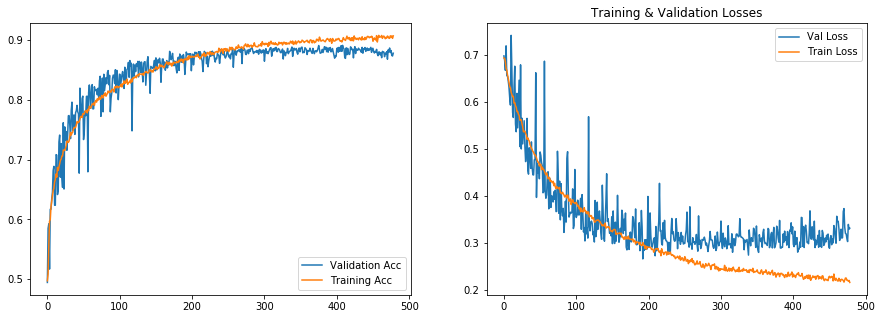

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# read the log file and filter the lines with training informations
x = open("train.log","r").readlines()
x =[k for k in x if k.startswith("Ep")]

# parse the training and testing accuracy
train_acc = [float(k.split(",")[1].split("=")[1]) for k in x if k.strip()]
test_acc = [float(k.split(",")[3].split("=")[1]) for k in x if k.strip()]

# parse the training and testing losses
val_loss = [float(k.split(",")[2].split("=")[1])/scalerVal for k in x if k.strip()]
traing_loss = [float(k.split(",")[0].split("=")[2])/scalerTr for k in x if k.strip()]

# plot results
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(test_acc,label = "Validation Acc")
ax[0].plot(train_acc,label = "Training Acc")
plt.title("Training & Validation Accuracy")
ax[0].legend()


scalerTr = Xtr.shape[0]/32
scalerVal = Xval.shape[0]/128
ax[1].plot(val_loss, label="Val Loss")
ax[1].plot(traing_loss, label="Train Loss")

plt.title("Training & Validation Losses")
plt.legend()


It turns out that the model started to overfit after 200 epochs. We have two options here, either we stop the training when we notice that we are starting to overfit, or we can keep records of the best model found during the whole training process. In our case, we opted for the second option because the validation loss wasn't smooth enough to notice if we are starting to overfit or not after a couple of epochs.

One of the techniques that we could use to improve the validation performance is Regularization using for instance L1/L2 penalization or Dropout, so we do not allow the model to overfit on the training set. The second improvement might be to use more data augmentation techniques, and the reason is the same, to avoid overfitting.

For different models, we can notice that the validation accuracy and the test accuracy (Kaggle) are roughly the same (around 89%).

# 3.Analysis and Experiments

## 3.1. Hyperparameters

We have tested a set of different hyperparameters, the following table shows a portion of the experiments we performed:



|batche_size|Epochs|learning rate|weight decay |Weight Update frequency|model name|val. accuracy|
|-----------|------|-------------|-------------|-----------------------|----------|-------------|
|400|600|0.05|1|-|Model1|0.79|
|200|500|0.05|1|-|Model2|0.82|
|200|500|0.05|1|-|Model3|0.85|
|800|800|0.1|0.9|30|Model3|0.87|
|32|450|0.1|0.97|3|Model3|**0.89**\*|
|500|1400|0.01|1|-|Model4|0.85|

**\* The best model accuracy**

We notice that the performence of the model increases with more flexible models until a certain limit where the performance starts to fall. At such level, the model is capable to overfit the training data.

## 3.2. Visualization of the results


Now that our model is trained, we would like to get some deeper understanding of what is happening inside the convolutional network. We decided to do the following:

- Visualize kernels

- Visualize the gradient of input layer

- Visualize feature maps

- Interpret some misclassifications by visualizing the CNN

For this part we load the weights from a pretrained model that we have constructed earlier in this exercice.

In [43]:
model.load_state_dict(torch.load("sb-modelBest-val-acc-6d-0.891.torch",map_location='cpu'))

In [44]:
params = dict(model.named_parameters())
params.keys()

dict_keys(['clf.0.weight', 'clf.0.bias', 'clf.2.weight', 'clf.2.bias', 'clf.5.weight', 'clf.5.bias', 'clf.8.weight', 'clf.8.bias', 'clf.11.weight', 'clf.11.bias', 'clf.13.weight', 'clf.13.bias', 'clf.16.weight', 'clf.16.bias', 'dense.0.weight', 'dense.0.bias', 'dense.1.weight', 'dense.1.bias'])

### Visualizing Kernels

In [220]:
def plot_kernels(k,i):
    """
    plot_kernels: shows a given channel of all kernels of the given layer number
    arguments: - k = given kernel number
               - i = given layer number
    """
    layer_params = params["clf."+str(i)+".weight"]
    # we visualize the channel number k of all kernels
    matrix = layer_params.data.numpy()[:,k,:]
    print("Kernel shape=",matrix.shape)
    # To show the channels in a grid form
    nrow, ncol = calculate_dims(matrix.shape[0])

    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.01, hspace=0.01, top=1.75*nrow, bottom=0, left=0, right=ncol) 


    for f in range(matrix.shape[0]):
        ax= plt.subplot(gs[f%nrow,f//nrow])
        ax.imshow(matrix[f,],cmap="gray")
        ax.axis('off')
        ax.set_title(str(f))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

Here we visualize the same channel number of each 32 kernels of the first layer. Black pixels represent low weights while white pixels are high weights of the kernels.

Kernel shape= (32, 3, 3)


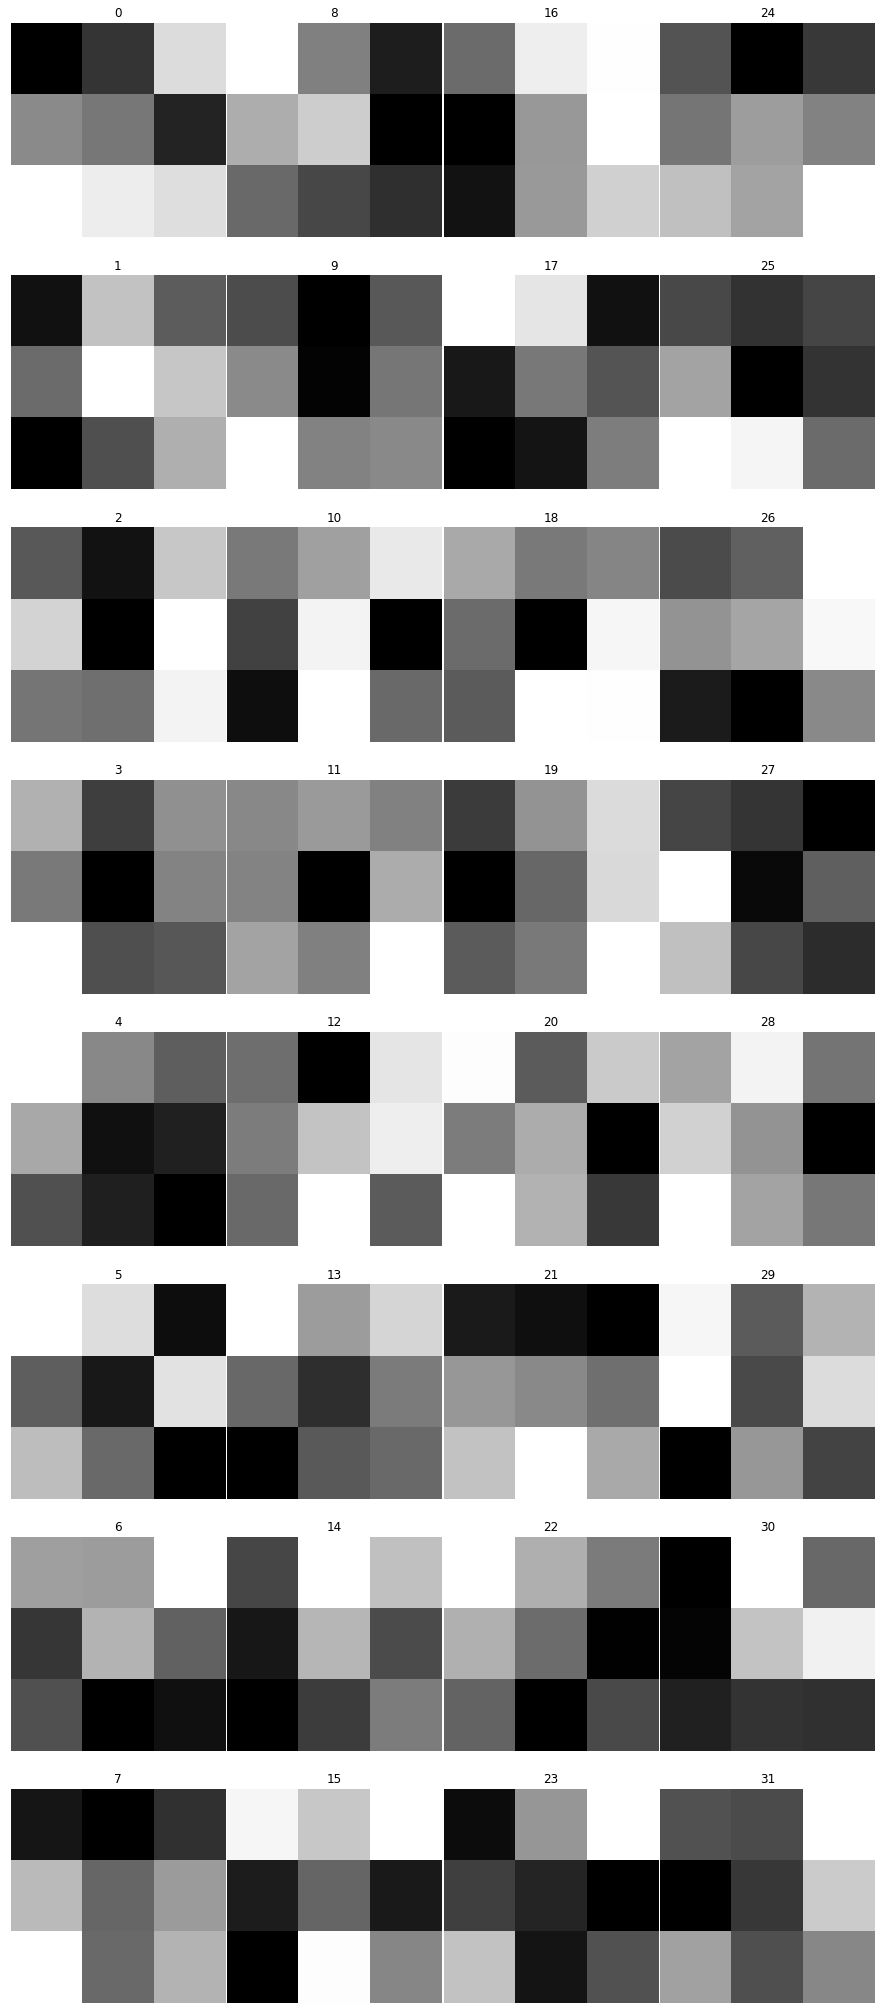

In [221]:
#Plot the first channel of every kernel of the first layer
plot_kernels(0,0)

We notice that several of the kernels of the first layer exhibit an oriented pattern, such that the convolution will detect corresponding edges of the input image. For example, we clearly see that the kernel 4 will detect gradient toward the top left corner, which probably correspond to round edges.

Kernel shape= (16, 5, 5)


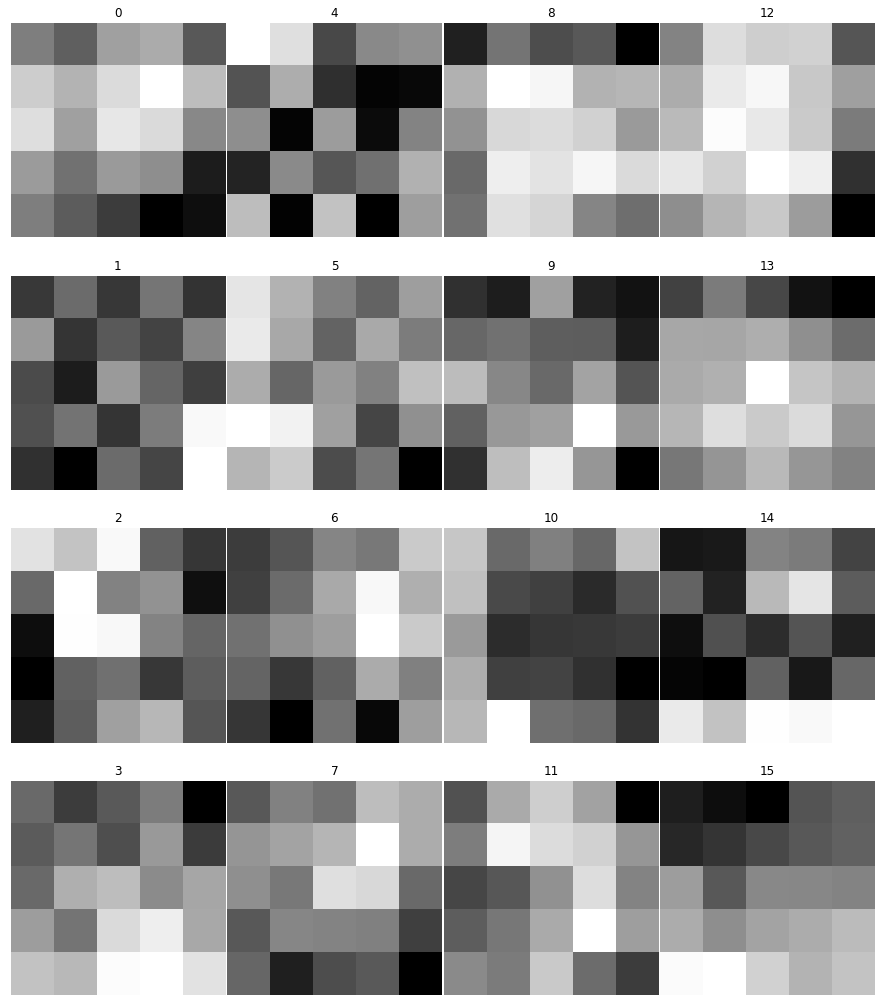

In [232]:
#Plot the first channel of every kernel of the last layer
plot_kernels(0,13)

We see that le last layer kernels exhibit more complicated patterns. However, due to the small size of the kernels, those patterns can not be as clearly interpreted as in the Zeiler & Fergus paper https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf.


### Visualizing Input layer Gradient 

In [160]:
def grad_visualize(indexes,train=True):
    """
    grad_visualize: shows the gradient of the input layer 
                    from a list of image indexes
    """
    if type(indexes) == int:
        indexes = [indexes]
    n = len(indexes)
    
    gs = gridspec.GridSpec(n, 2,
             wspace=.1, hspace=0.1, top=1.5*n, bottom=0, left=0, right=2) 
    # Iterate over indexes
    for i,idx in enumerate(indexes):
        if train:
            img,label = train_dataset.__getitem__(idx,use_transforms=False)
        else:
            img,label = val_dataset.__getitem__(idx,use_transforms=False)

        input_img = Parameter(img.reshape(1,*img.shape), requires_grad=True)

        if input_img.grad is not None:
            input_img.grad.data.zero_()
        model.zero_grad()
        
        #Forward
        out = model(input_img).cpu()
        loss = criterion(out,torch.Tensor([label]).long())
        
        #Backward
        loss.backward()
        
        # Takes the maximum absolute gradient value across the 3 channels
        grad_img = np.abs(input_img.grad[0,:].numpy()).max(axis=0)

        ax= plt.subplot(gs[i,0])
        if train:
            ax.imshow(Xtr[idx])
        else:
            ax.imshow(Xval[idx])
        ax.set_title("Original Image")
        ax.axis('off')

        ax= plt.subplot(gs[i,1])
        ax.imshow(grad_img)
        ax.set_title("Gradient")
        ax.axis('off')

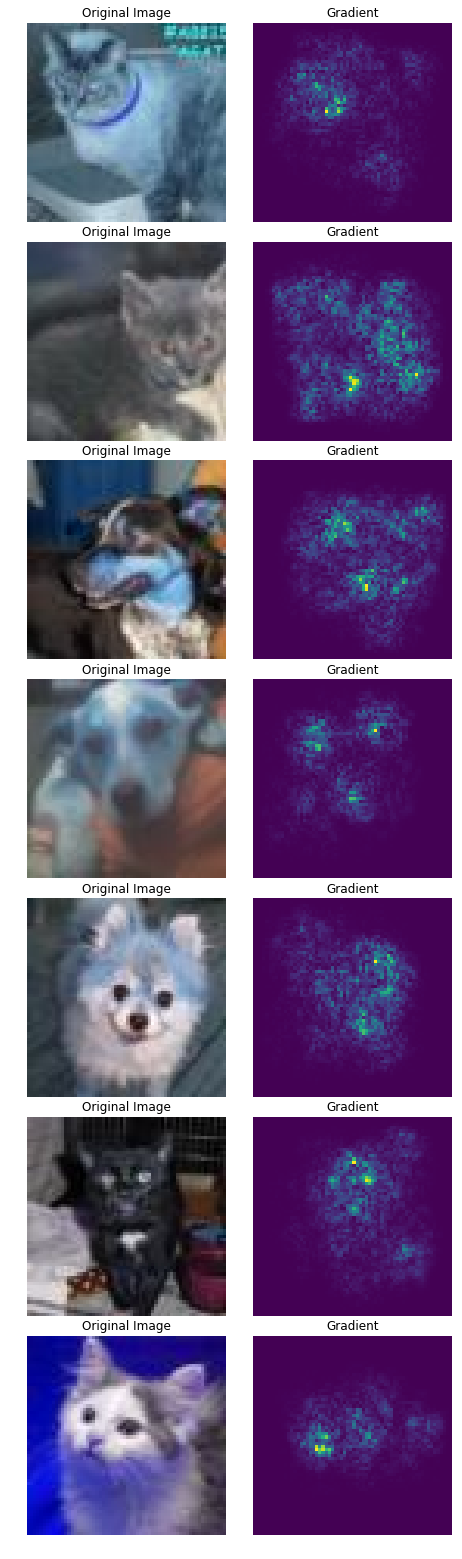

In [247]:
grad_visualize([14,3,9874,10000,9103,2,3000])

As we can see above, the points where we have the maximum gradient/impact on the loss are mostly located on the face zone in the image. This can be explained by the fact that the model is at an advanced phase on training and now it's more focusing on complicated patterns, such as face textures.

Plus, we also notice that the most important parts that affect the loss function are related to the muzzle and the eyes of the animal.

### Visualizing feature maps

In [50]:
summary(model,(3,64,64),1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 62, 62]             896
              ReLU-2            [1, 32, 62, 62]               0
            Conv2d-3            [1, 64, 60, 60]          18,496
         MaxPool2d-4            [1, 64, 58, 58]               0
              ReLU-5            [1, 64, 58, 58]               0
            Conv2d-6           [1, 128, 54, 54]         204,928
         MaxPool2d-7           [1, 128, 52, 52]               0
              ReLU-8           [1, 128, 52, 52]               0
            Conv2d-9            [1, 64, 48, 48]         204,864
        MaxPool2d-10            [1, 64, 46, 46]               0
             ReLU-11            [1, 64, 46, 46]               0
           Conv2d-12            [1, 32, 21, 21]          51,232
             ReLU-13            [1, 32, 21, 21]               0
           Conv2d-14              [1, 1

To implement feature maps visualization, we got the idea from the Pytorch forum.

https://discuss.pytorch.org/t/visualizing-different-layers-of-neural-network/13381/2

In [239]:
class ModelLayer(nn.Module):
    """
    ModelLayer: Helps us get the output of the layer_id by:
                - feeding the NN an image
                -Performing forzard propagation until the layer_id
    """
    def __init__(self,model,layer_id):
        super(ModelLayer, self).__init__()
        self.features = nn.Sequential(
            *list(model.clf.children())[:layer_id]
        )
    def forward(self, x):
        x = self.features(x)
        return x

In [240]:
def visualize_feature_maps(layer_id,idx,train=True):
    """
    visualize_feature_maps: takes a layer_id and an image index, shows the corresponding feature maps.
    To make it more easy, we'll show the original image, the feature maps, and the mean of those feature maps.
    """
    if train:
        img,label = train_dataset.__getitem__(idx,use_transforms=False)
    else:
        img,label = val_dataset.__getitem__(idx,use_transforms=False)
    input_img = Parameter(img.reshape(1,*img.shape), requires_grad=True)

    layer_2 = ModelLayer(model,layer_id)
    out_layer2 = layer_2.forward(input_img).data.numpy()[0]
    print("layer shape:",out_layer2.shape)
    
    nrow,ncol = calculate_dims(out_layer2.shape[0])
    gs = gridspec.GridSpec(1, 2,
             wspace=0.1, hspace=0.1, top=1, bottom=0, left=0, right=2) 
    ax= plt.subplot(gs[0,0])
    if train:
        ax.imshow(Xtr[idx])
    else:
        ax.imshow(Xval[idx])
    ax.set_title("Original Image")
    ax.axis('off')
    
    ax= plt.subplot(gs[0,1])
    ax.set_title("Features Mean")
    ax.imshow(np.mean(out_layer2,axis=0))
    ax.axis('off')
    plt.show()
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.1, hspace=0.1, top=1.5*nrow, bottom=0, left=0, right=ncol) 
    
    for f in range(out_layer2.shape[0]):
        ax= plt.subplot(gs[f%nrow,f//nrow])
        ax.imshow(out_layer2[f,])
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

layer shape: (16, 7, 7)


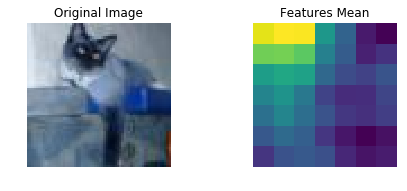

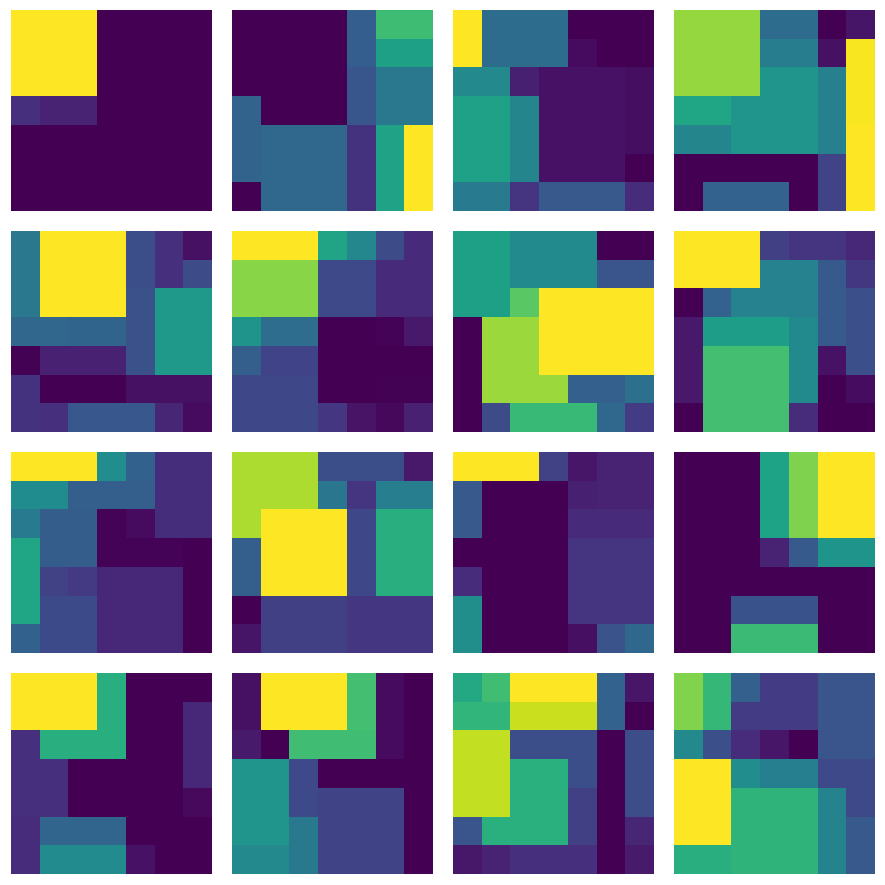

In [253]:
# We then visualize 
visualize_feature_maps(16,13)

layer shape: (32, 62, 62)


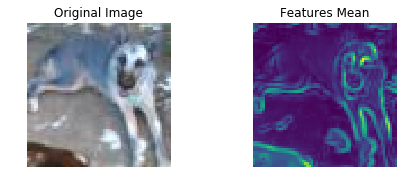

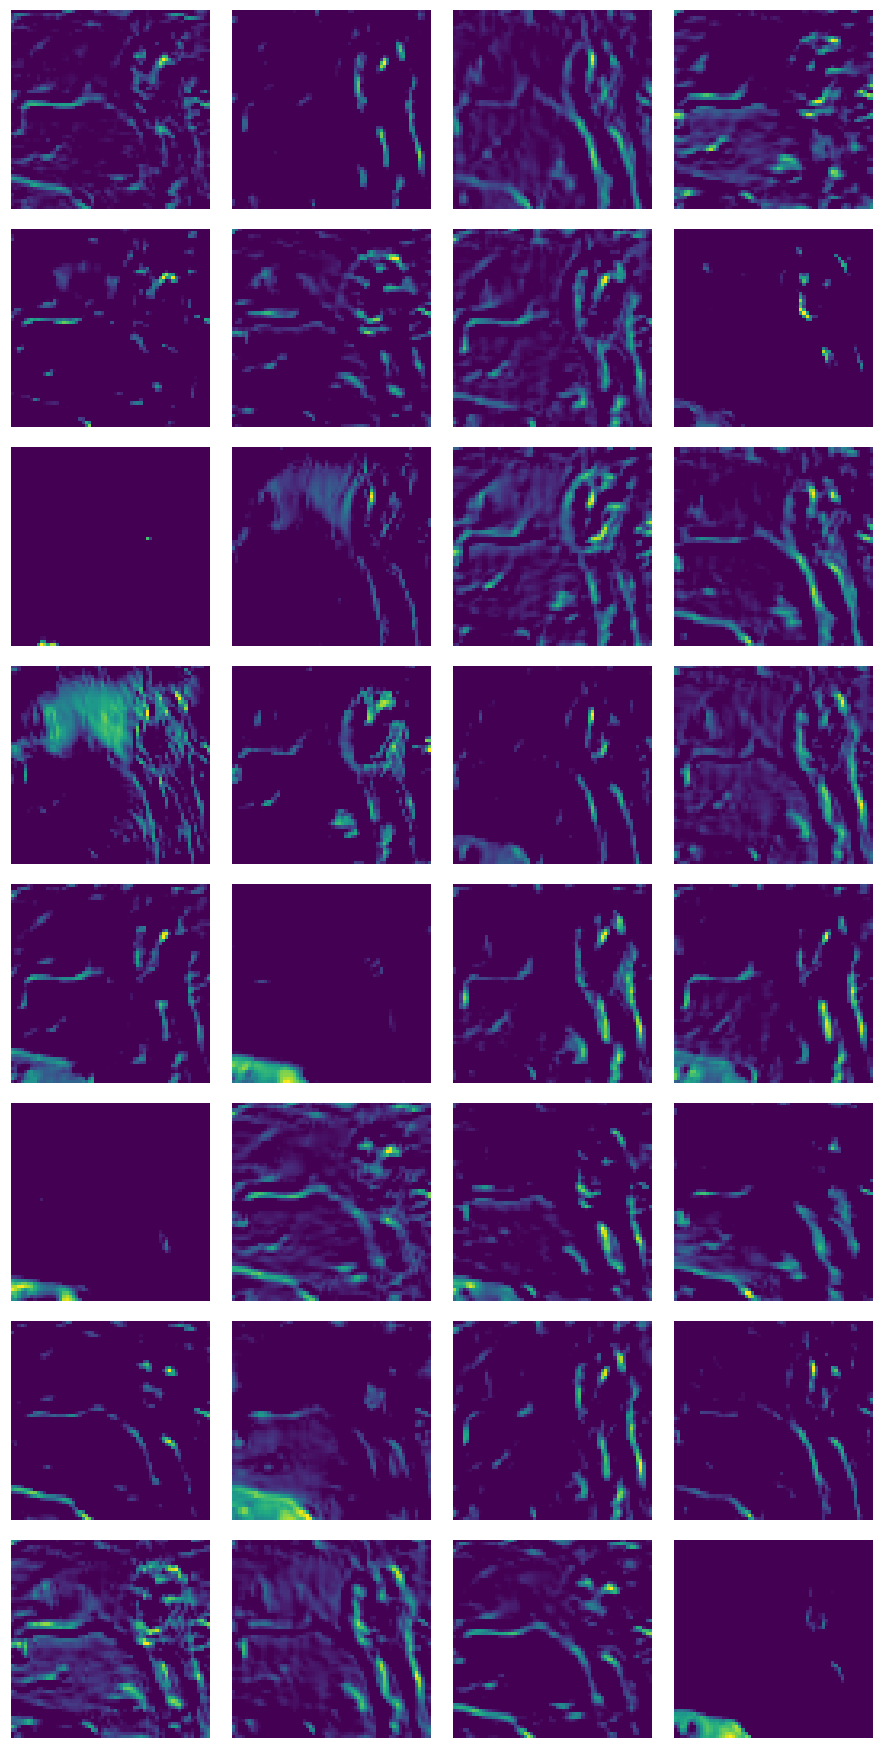

In [151]:
visualize_feature_maps(2,11130)

layer shape: (32, 21, 21)


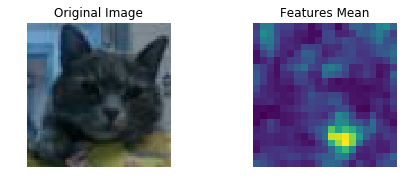

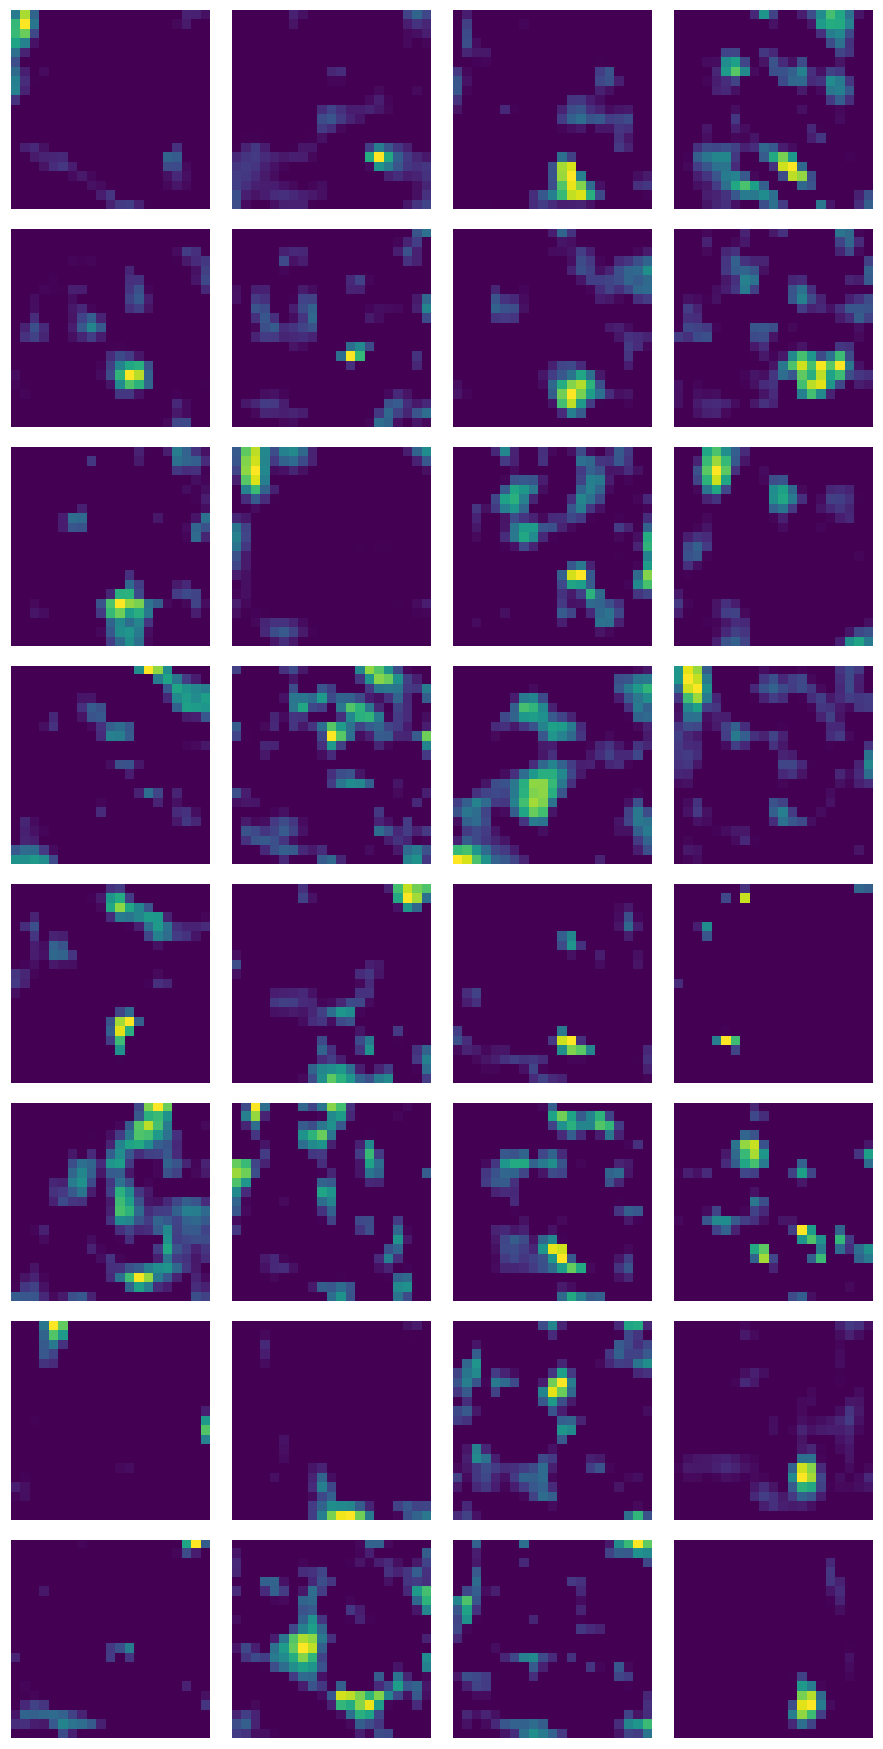

In [152]:
visualize_feature_maps(13,10)

layer shape: (32, 21, 21)


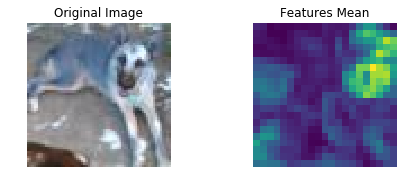

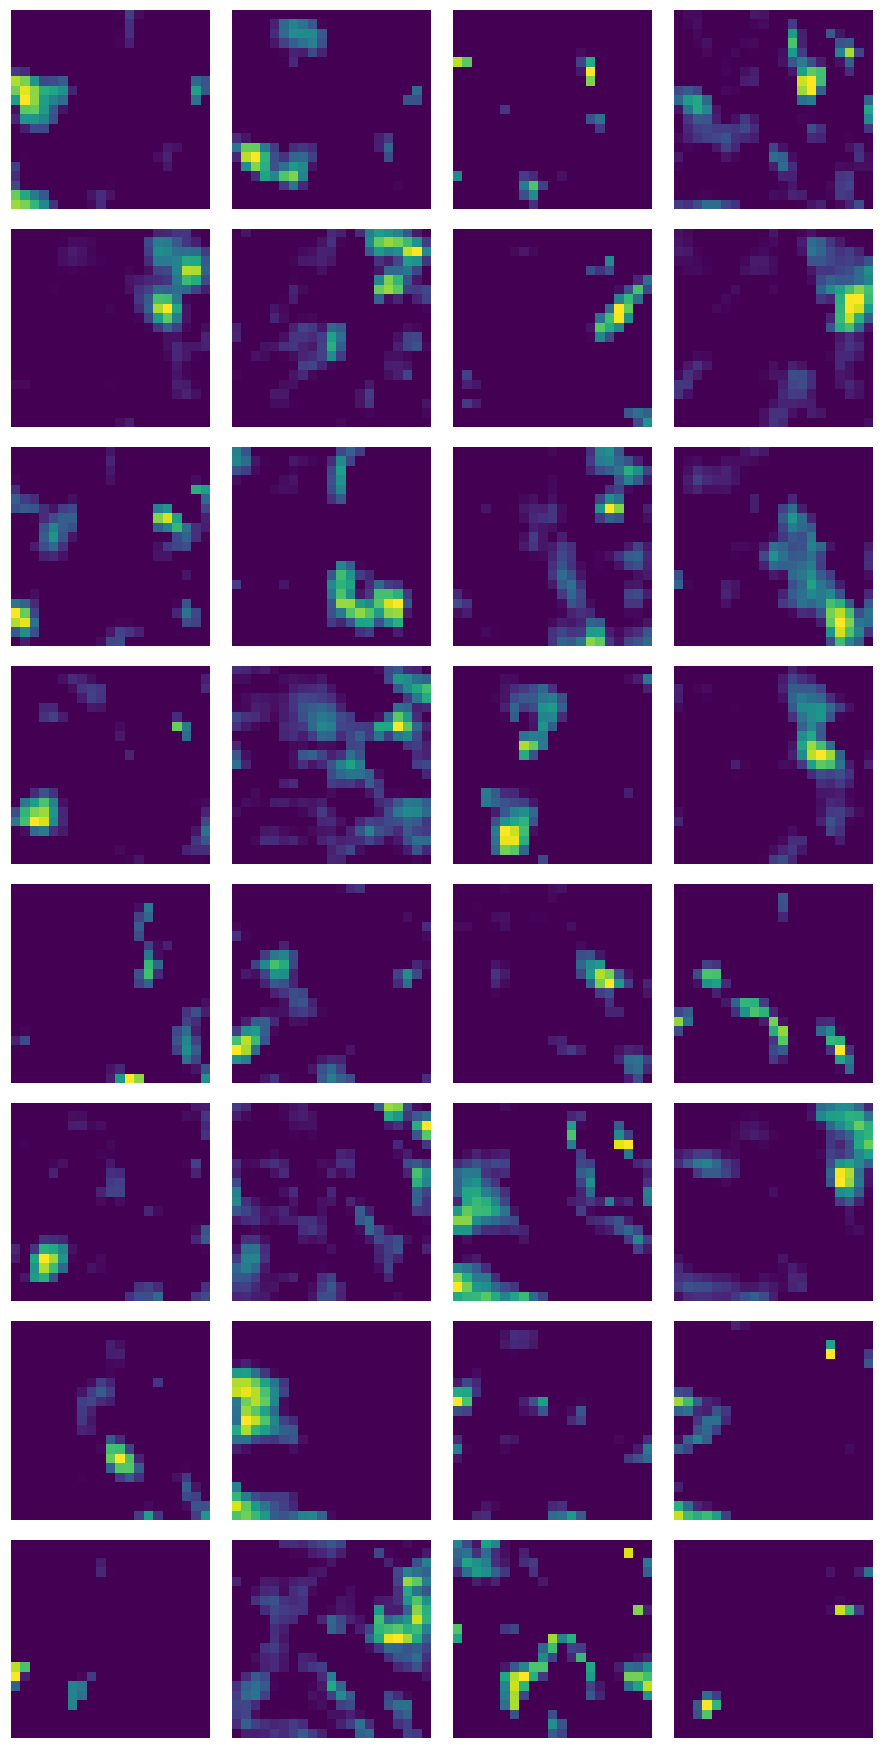

In [153]:
visualize_feature_maps(13,11130)

# Visualizing missclassified images

In [58]:
def predict(model,loader):
    """
    predict: predict image class
    output: - probas : a vector of probabilities for class 1: Dog
            - predicted : the predicted class for each image
            - ground_tr : the real target for each image
    """
    predicted = []
    probas = []
    ground_tr = []
    with torch.no_grad():
        for i, tData in enumerate(loader):
            print(".",end="")
            tX_batch, tY_batch = tData
            if torch.cuda.is_available():
                tX_batch = tX_batch.cuda()
                tY_batch = tY_batch.cuda()
            out = model(tX_batch)
            probas_out = torch.nn.Softmax(dim=1).forward(out)[:,1].data.numpy()
            predicted += np.argmax(out.numpy(),axis=1).tolist()
            probas+=probas_out.tolist()
            ground_tr += tY_batch.numpy().tolist()
    
    predicted = np.array(predicted)
    probas = np.array(probas)
    
    ground_tr = np.array(ground_tr)
    return ground_tr, predicted, probas

In [59]:
val_loader = utils.data.DataLoader(val_dataset, batch_size=128, num_workers=4)
ground_tr, predicted, probas = predict(model,val_loader)

............................

In [70]:
distance_probas_middle = abs(0.5 - probas)
mis_classified = np.where(predicted!=ground_tr)

sorted_idx = np.argsort(distance_probas_middle)
mis_clf_idx = sorted_idx[np.isin(sorted_idx,mis_classified)]
mis_clf_probas = probas[mis_clf_idx]


array([0.50071728, 0.50081253, 0.49761525, 0.50294161, 0.50405365,
       0.49482799, 0.49143448, 0.50947213, 0.49038985, 0.48997381])

In [138]:

def show_images(data,indexes,probas):
    plt.rcParams['figure.figsize'] = 3, 2
    nrow,ncol = calculate_dims(len(indexes))
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.1, hspace=0.1, top=1.5*nrow, bottom=0, left=0, right=ncol) 

    for i in range(nrow):
        for j in range(ncol):
            ax= plt.subplot(gs[i,j])
            ax.imshow(data[indexes[j*nrow+i]])
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ttl = f"ID:{indexes[j*nrow+i]} Dog {probas[j*nrow+i]:.3f}" if probas[j*nrow+i]>0.5 else f"ID:{indexes[j*nrow+i]} Cat {1-probas[j*nrow+i]:.3f}"
            ax.set_title(ttl)
    plt.show()
    

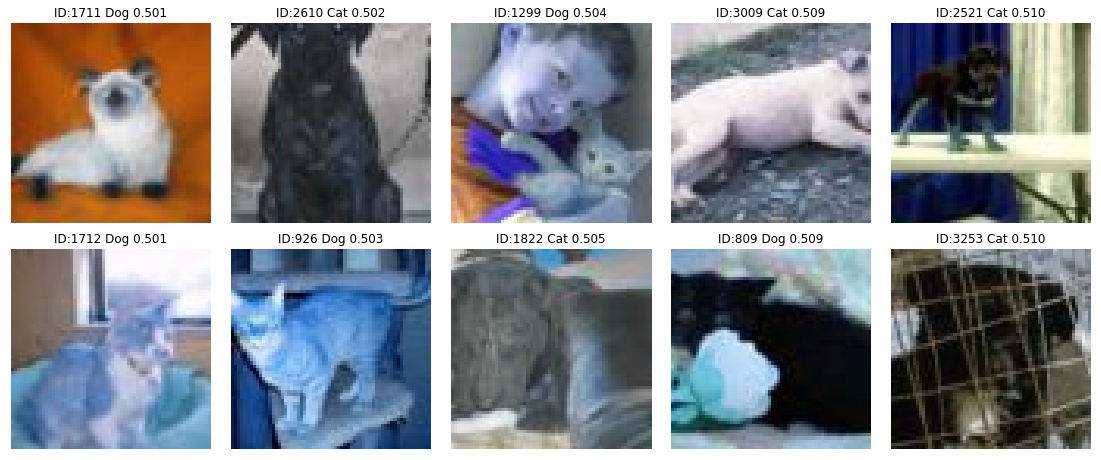

In [139]:
show_images(Xval,mis_clf_idx[:10],mis_clf_probas[:10])

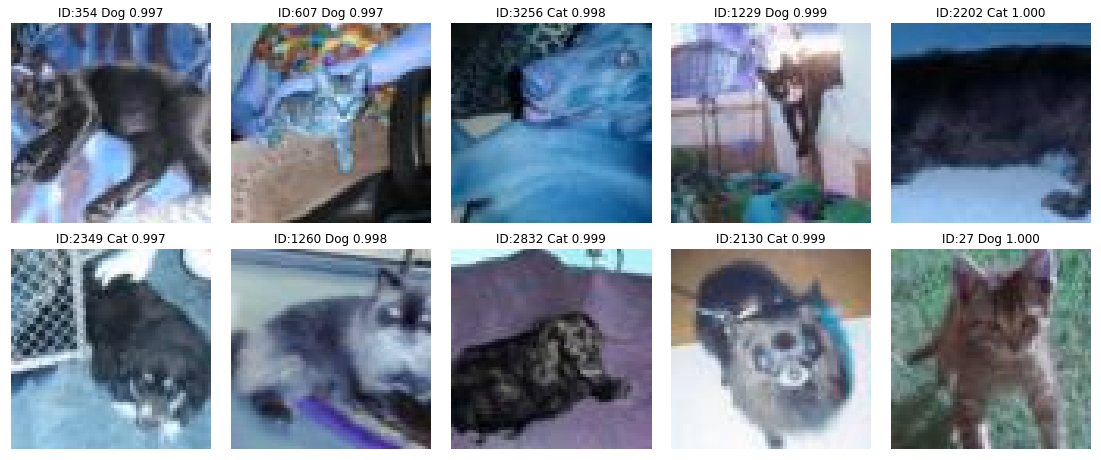

In [140]:
show_images(Xval,mis_clf_idx[-10:],mis_clf_probas[-10:])

layer shape: (32, 62, 62)


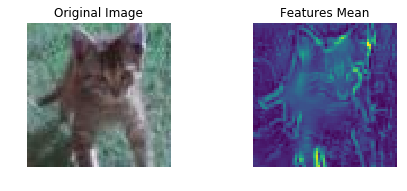

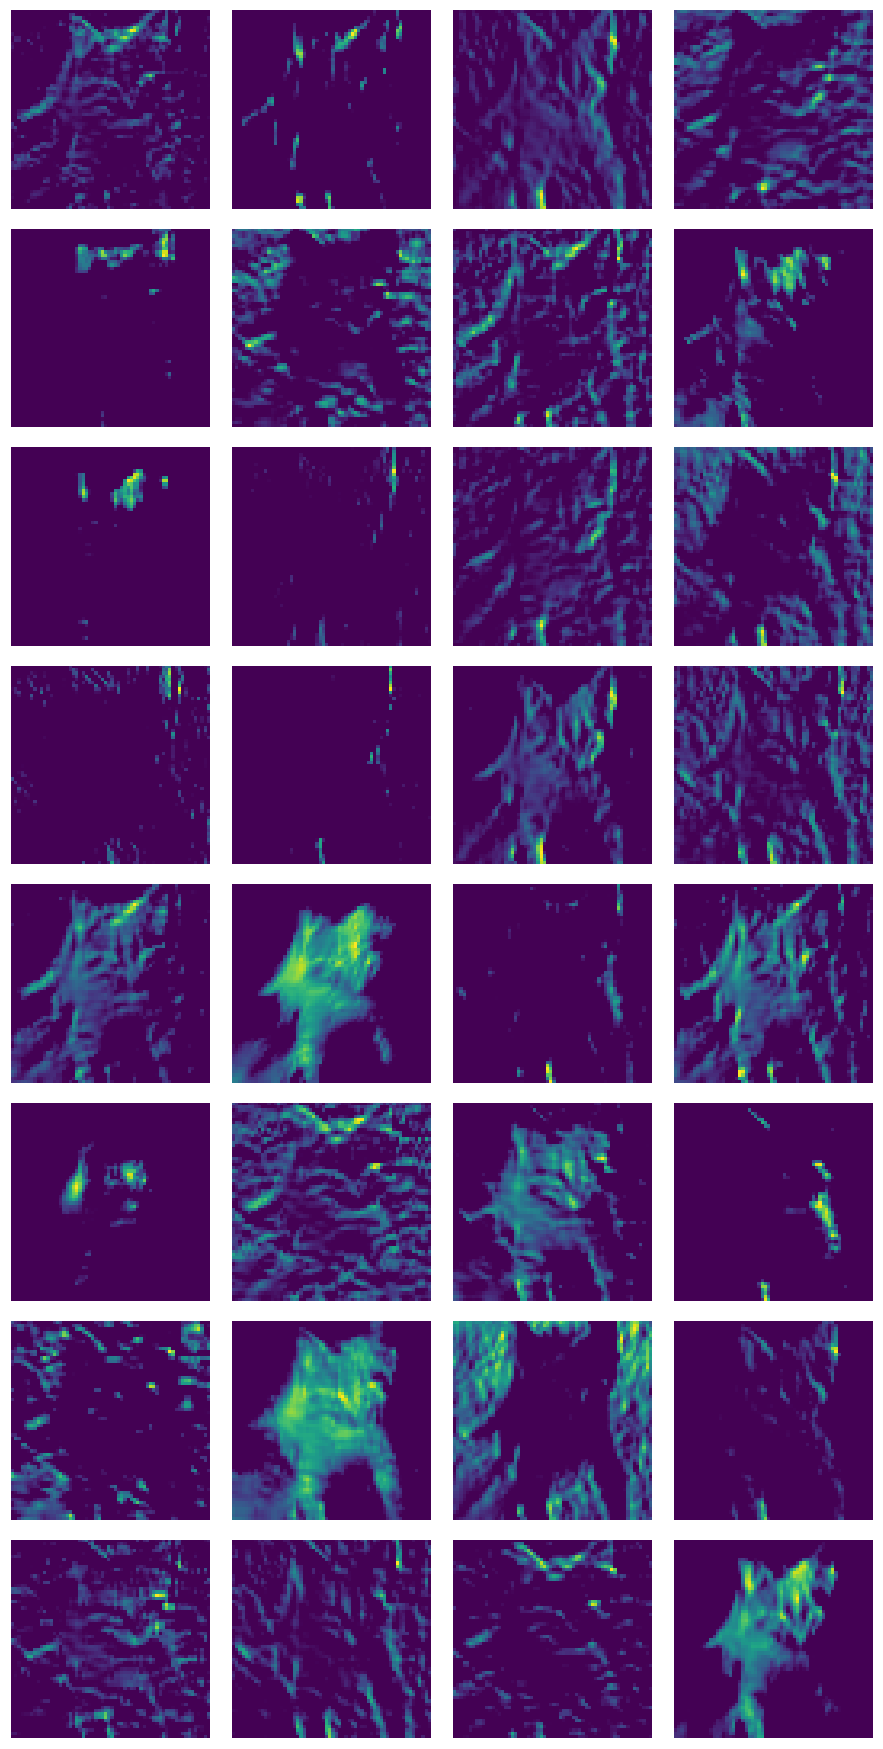

In [154]:
visualize_feature_maps(2,27,train=False)

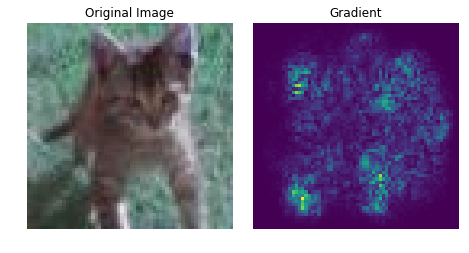

In [169]:
grad_visualize(27,False)